---


#PROYECTO FINAL: CLASIFICACION DE IMAGENES 


**EGUIVAR VILLCA SHIRLEY CARMINIA**


---



In [1]:
# import dependencies
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Dropout
from keras.layers import Flatten
from keras.constraints import maxnorm
#from keras.optimizers import SGD
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.optimizers import Adam
from keras.layers.convolutional import Conv2D
from keras.layers.convolutional import MaxPooling2D
from keras.utils import np_utils
# import cifar10dataset
from keras.datasets import cifar10
import matplotlib.pyplot as plt
import numpy as np
import time


##Configuracion del Modelo(Definicion de variables)

---
**The batch size** is the amount of samples that will be fed forward in your model at once, after which the loss value is computed. You could either feed the model the entire training batch, one sample every time or a minibatch – and you can set this value by specifying batch_size.

The **image width**, **image height** and **number of channels**. Width and height are 32, respectively, and number of channels is 3, as the dataset contains RGB images.

The **loss function** used to compare predictions with ground truth during training. We use sparse categorical crossentropy loss. We skip the “why” for now – I’ll show you later why we use sparse instead of regular categorical crossentropy loss.

The **number of classes** and **number of epochs** (or iterations).

The **optimizer**, or the method by which we update the weights of our neural network. .

**Verbosity mode** is set to “1”, which means “True”, which means that all the output is displayed on screen. This is good for understanding what happens during training, but it’s best to turn it off when you actually train models, as it slows down the training process



In [7]:
# Model configuration
batch_size = 50
img_width, img_height, img_num_channels = 32, 32, 3
loss_function = 'categorical_crossentropy'
no_classes = 10   # the dataset have 10 classes airplane, dog, cat,truck,horse,car,frog,ship,bird,deer
no_epochs = 60   # num to iterate, it can b change to 100, with 100 epochs we shoud have  the best result
optimizer = SGD()#Adam()#SGD()#
verbosity = 1

##Loading & preparing CIFAR-10 data

---



In [9]:

# Load CIFAR-10 data 
(train_X,train_Y),(test_X,test_Y)=cifar10.load_data()



##Determine shape of the data

---



El siguiente paso es determinar la forma de una muestra. Keras requiere esto para comprender qué datos puede esperar en la INPUT LAYER de su red neuronal. 



In [10]:
# Determine shape of the data, in this case 32,32,3
#it means 32 pixeles x 32 pixeles x 3 canales(RGB)  , 
# There are 3 channels becouse the images have colours
input_shape = (img_width, img_height, img_num_channels) 
 
print("Shape of x_train: {}".format(train_X.shape))
print("Shape of y_train: {}".format(train_Y.shape))
print()
print("Shape of x_test: {}".format(test_X.shape))
print("Shape of y_test: {}".format(test_Y.shape))

Shape of x_train: (50000, 32, 32, 3)
Shape of y_train: (50000, 1)

Shape of x_test: (10000, 32, 32, 3)
Shape of y_test: (10000, 1)


In [11]:
!pip3 install SGD
!pip install -U tensorflow-addons

ERROR: Could not find a version that satisfies the requirement SGD (from versions: none)
ERROR: No matching distribution found for SGD
     |████████████████████████████████| 1.1 MB 32.2 MB/s 


Image (#2107): Which is label number '[0]', or label 'airplane''


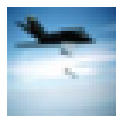

In [15]:
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
sample = 2107 
each = train_X[sample]

plt.figure(figsize=(2,2))
plt.axis('off')
plt.imshow(each, interpolation='nearest')
print("Image (#{}): Which is label number '{}', or label '{}''".format(sample,train_Y[sample], labelNames[train_Y[sample][0]]))

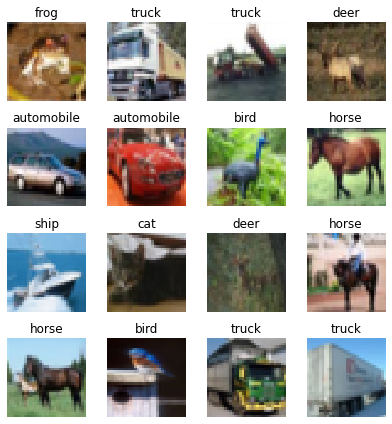

In [16]:
ROW = 4
COLUMN = 4
plt.figure(figsize=(6, 6)) 
for i in range(ROW * COLUMN):
    image = train_X[i] 
    plt.subplot(ROW, COLUMN, i+1)       
    plt.imshow((image).astype(np.uint8), interpolation='nearest')  
    #plt.title('label = {}'.format(labelNames[train_Y[i][0]]))
    plt.title('{}'.format(labelNames[train_Y[i][0]]))
    #plt.imshow((out * 255).astype(np.uint8))
    plt.axis('off')
    plt.tight_layout()   
    
plt.show()


##Data Procesing

---

Convertimos la data en el formato float32 , esto deberia acelerar el training. Luego normalizamos la data , n el rango [−1,1] 

In [17]:
# Checking the minimum and maximum values of x_train
print(train_X.min())
print(train_X.max())

0
255


In [18]:
# Parse numbers as floats
train_x=train_X.astype('float32')
test_X=test_X.astype('float32')
# Normalize data 
## the max value is 255, that is the reason why we divide with that num
train_X=train_X/255.0
test_X=test_X/255.0

In [19]:
train_Y=np_utils.to_categorical(train_Y)
test_Y=np_utils.to_categorical(test_Y)
 
num_classes=test_Y.shape[1]

## Build the architecture of the Model  (CNN) 

---


my CNN architechture is  **In -> [[Conv2D  ->relu] -> MaxPool2D]* 3 -> Flatten -> Dense -> Out**

Primero, crearemos una instancia de la API secuencial y la asignaremos al modelo; esto es como un  tablero de Lego en el que puede agregar ladrillos, también conocidos como capas.
A continuación, es hora de apilar algunas capas. 

En primer lugar, usaremos tres bloques convolucionales,cada bloque esta compuesto po la capa
convolucionales con algunas relacionadas. En este caso, la capa relacionada que se aplica cada vez es una MaxPooling2D directamente después de la capa Conv2D. Como puede ver, cada vez, el número de mapas de características aumenta, de 32 a 64 a 128. Esto se hace porque el modelo aprende un número limitado de patrones "genéricos" (32) y una gran cantidad de patrones únicos. a la imagen (128). Max Pooling asegura la invariancia de traducción.

Después de los bloques convolucionales, agregamos una capa Flatten. Las capas densas, que se encargan de generar las clasificaciones reales, solo funcionan con datos unidimensionales. Flatten hace que esto suceda: convierte los mapas de características multidimensionales en una forma unidimensional. 

Mientras usamos la función de activación de Softmax, obtendremos una distribución de probabilidad multiclase discreta como nuestra salida para cualquier entrada. A partir de esta distribución, podemos extraer la que tenga 3el valor más alto, que es la clase más probable para nuestra entrada.

In [20]:
#model=Sequential()
#model.add(Conv2D(32,(3,3),input_shape=(32,32,3),padding='same',activation='relu',kernel_constraint=maxnorm(3)))
#model.add(Dropout(0.2))
#model.add(Conv2D(32,(3,3),activation='relu',padding='same',kernel_constraint=maxnorm(3)))
#model.add(MaxPooling2D(pool_size=(2,2)))
#model.add(Flatten())
#model.add(Dense(512,activation='relu',kernel_constraint=maxnorm(3)))
#model.add(Dropout(0.5))
#model.add(Dense(num_classes, activation='softmax'))

model = Sequential()
model.add(Conv2D(32, kernel_size=(3, 3), activation='relu', input_shape=(32,32,3)))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(64, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(128, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

In [21]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 30, 30, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 15, 15, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 13, 13, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 6, 6, 64)         0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 4, 4, 128)         73856     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 2, 2, 128)        0

##Compiling the model & fitting data

---



In [22]:
# Compile the model
model.compile(loss=loss_function,
              optimizer=optimizer,
              metrics=['accuracy'])


In [23]:
start1 = time.time()


# Fit data to model
history = model.fit(train_X, train_Y,
            batch_size=batch_size,
            epochs=no_epochs,
            verbose=verbosity,
            validation_data=(test_X,test_Y)
            )
end1 = time.time()
cnn_time = end1-start1


Epoch 1/60
1000/1000 [==============================] - 70s 69ms/step - loss: 2.1663 - accuracy: 0.1956 - val_loss: 2.0633 - val_accuracy: 0.2292
Epoch 2/60
1000/1000 [==============================] - 69s 69ms/step - loss: 1.9070 - accuracy: 0.3018 - val_loss: 1.7527 - val_accuracy: 0.3654
Epoch 3/60
1000/1000 [==============================] - 68s 68ms/step - loss: 1.6935 - accuracy: 0.3858 - val_loss: 1.6330 - val_accuracy: 0.4148
Epoch 4/60
1000/1000 [==============================] - 70s 70ms/step - loss: 1.5590 - accuracy: 0.4359 - val_loss: 1.5313 - val_accuracy: 0.4505
Epoch 5/60
1000/1000 [==============================] - 73s 73ms/step - loss: 1.4681 - accuracy: 0.4696 - val_loss: 1.4368 - val_accuracy: 0.4804
Epoch 6/60
1000/1000 [==============================] - 71s 71ms/step - loss: 1.3869 - accuracy: 0.5018 - val_loss: 1.3539 - val_accuracy: 0.5100
Epoch 7/60
1000/1000 [==============================] - 71s 71ms/step - loss: 1.3153 - accuracy: 0.5311 - val_loss: 1.2832 -

In [24]:
#from sklearn.metrics import accuracy_score
from sklearn import metrics
pred_Y = model.predict(test_X) 

##Generating evaluation metrics & visualizations

---
Asignamos los resultados de model.fit a un objeto history. Esto nos permitirá ver los resultados de las pruebas

In [25]:
# cm is the confusion matrix, names are the names of the classes.
def plot_confusion_matrix(cm, names, title='Confusion matrix', cmap=plt.cm.Blues):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(names))
    plt.xticks(tick_marks, names, rotation=90)
    plt.yticks(tick_marks, names)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

-----------------CNN Summary---------------
CNN Time: 72.37 minute
F1 score: 0.6826686917310868
Accuracy score: 0.6838
Confusion matrix: 
 [[658  30  35  18  35   6  13   9 147  49]
 [ 17 764   6  11   2   6  16   1  55 122]
 [ 50  11 534  80 118  64  52  30  34  27]
 [ 17  14  61 507  86 174  46  32  28  35]
 [ 14   3  54  61 707  43  33  51  24  10]
 [  7   7  49 173  68 582  25  49  17  23]
 [  4   9  38  66  57  23 760   4  16  23]
 [ 20   8  26  47 111  77   5 652   8  46]
 [ 27  27   6  12  11   9   1   4 863  40]
 [ 21  58  10  13   8  11   5  13  50 811]]
Plotting confusion matrix


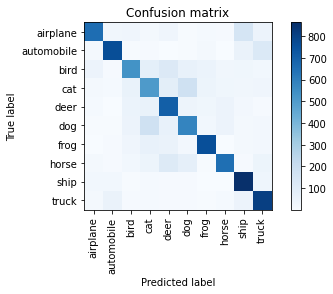

              precision    recall  f1-score   support

           0       0.79      0.66      0.72      1000
           1       0.82      0.76      0.79      1000
           2       0.65      0.53      0.59      1000
           3       0.51      0.51      0.51      1000
           4       0.59      0.71      0.64      1000
           5       0.58      0.58      0.58      1000
           6       0.79      0.76      0.78      1000
           7       0.77      0.65      0.71      1000
           8       0.69      0.86      0.77      1000
           9       0.68      0.81      0.74      1000

    accuracy                           0.68     10000
   macro avg       0.69      0.68      0.68     10000
weighted avg       0.69      0.68      0.68     10000



In [26]:
# CNN report and analysis
#y_pred_svc = svc.predict(test_Y)
import numpy as np
yPred = np.argmax(pred_Y, axis=1)
yTest =np.argmax(test_Y, axis=1)
labelNames = ["airplane", "automobile", "bird", "cat", "deer", "dog", "frog", "horse", "ship", "truck"]
cnn_f1 = metrics.f1_score(yTest, yPred, average= "weighted")
cnn_accuracy = metrics.accuracy_score(yTest, yPred)
cnn_cm = metrics.confusion_matrix(yTest, yPred)
print("-----------------CNN Summary---------------")
print("CNN Time: {:0.2f} minute".format(cnn_time/60.0))
print("F1 score: {}".format(cnn_f1))
print("Accuracy score: {}".format(cnn_accuracy))
print("Confusion matrix: \n", cnn_cm)
print('Plotting confusion matrix')

plt.figure()
plot_confusion_matrix(cnn_cm, labelNames)
plt.show()

print(metrics.classification_report(yTest, yPred))

##Conclusion

---
En aproximadamente el 70% de los casos, nuestro modelo son correctos. Esto está en línea con las precisiones de validación visualizadas a continuación a través de las épocas. Pero, lo que es más importante,  Al principio, la pérdida bajó bastante rápido, alcanzó un mínimo alrededor de la quinta época y luego volvió a subir, sustancialmente.

Esta es una clara señal de que nuestro modelo está sobreajustado o de que está muy adaptado a nuestro conjunto de datos de entrenamiento. Esto puede significar que su rendimiento en datos que nunca antes ha visto es peor que si el proceso de entrenamiento se detuviera en, p. Ej. la quinta época.


In [ ]:
#model.save("imageClassifier_CNN_Eguivar.h5")

## Tests examples


---



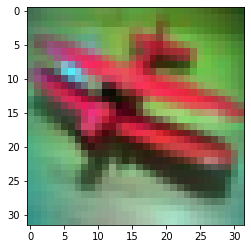

In [ ]:
import numpy as np 
from keras.preprocessing import image
# Give the link of the image here to test 
test_image =image.load_img('0032.png',target_size =(32,32))
import matplotlib.pyplot as plt 
plt.imshow(test_image)

In [ ]:
test_image =image.img_to_array(test_image) 
test_image =np.expand_dims(test_image, axis =0) 
result = model.predict(test_image) 
print(result) 
if result[0][0]==1: 
    print("Airplane") 
elif result[0][1]==1: 
    print('Automobile') 
elif result[0][2]==1: 
    print('Bird') 
elif result[0][3]==1: 
    print('Cat') 
elif result[0][4]==1: 
    print('Deer') 
elif result[0][5]==1: 
    print('Dog') 
elif result[0][6]==1: 
    print('Frog') 
elif result[0][7]==1: 
    print('Horse') 
elif result[0][8]==1: 
    print('Ship') 
elif result[0][9]==1: 
    print('Truck') 
else: 
    print('Error')
#%matplotlib inline 
#import matplotlib.pyplot as plt 
#plt.imshow(test_image)

[[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.]]
Airplane
